In [10]:
def comp_Zca(lx, a, dt=1, strict=False, dx=1e-3, zcmin=1e-8, mindx=1e-3):
    import math
    dzc={}
    tmax=len(lx)
    for i in range(0,tmax-dt):
        x=lx[i+dt]
        lastx=lx[i]
        d=abs(x-lastx)
        if a<0 and d<mindx:d=mindx
        if a==0: d=1 
        else: d=float(d)**a
        if dx!=None and not strict: 
            x=math.floor(x/dx)*dx
            lastx=math.floor(lastx/dx)*dx
        if lastx<x:
            dzc[lastx]=dzc.get(lastx,0)+d
            dzc[x]=dzc.get(x,0)-d
        else:  
            dzc[x]=dzc.get(x,0)+d
            dzc[lastx]=dzc.get(lastx,0)-d
    keys=list(dzc.keys())
    keys.sort()
    lx=[]
    ly=[]
    z=0
    for x in keys:
        lx.append(x)
        ly.append(float(z)/dt/2)
        z=z+dzc[x]
        if strict:
            lx.append(x)
            y=float(z)/dt/2
            if y<zcmin: y=0.0
            ly.append(y)
    if not strict:
        ly[0]=ly[1] # ly[0] equals 0, but a non-zero value is more convenieint for further analysis
    return lx,ly 


def comp_Zh(lx,dx):
    import math
    zh={}
    for x in lx:    
        x=math.floor(x/dx+0.5)*dx
        zh[x]=zh.get(x,0)+1
    for x in zh:zh[x]=float(zh[x])/dx
    lx=list(zh.keys())
    lx.sort()
    ly=[zh[x] for x in lx]
    return lx,ly

In [11]:
f=open('redtraj-5-0.rmsd')
traj=[]
for l in f:
    l=l.split()
    traj.append(float(l[1]))
f.close()

In [12]:
import math

# specifying the drift
def f(x):
    return -x

# specifying the diffusion coefficient
def D(x):
    return (1+math.cos(x))/2

dt=0.01

import matplotlib.pyplot as plt

<ipython-input-13-d3ee7780847d>:7: RuntimeWarning: divide by zero encountered in log
  _=plt.plot(lx,np.log(ly))


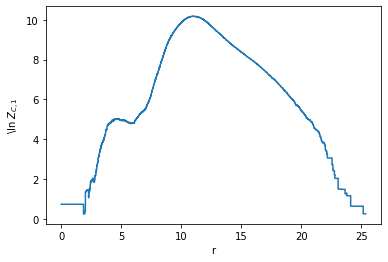

In [13]:
from math import sin,cos,pi,log,exp
import numpy as np

lx,ly=comp_Zca(traj,a=1,strict=True)
plt.xlabel('r')
plt.ylabel('\ln $Z_{C,1}$')
_=plt.plot(lx,np.log(ly))

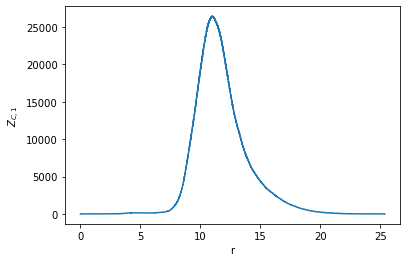

In [14]:
lx,ly=comp_Zca(traj,a=1,strict=True)
plt.xlabel('r')
plt.ylabel('$Z_{C,1}$')
_=plt.plot(lx,ly)

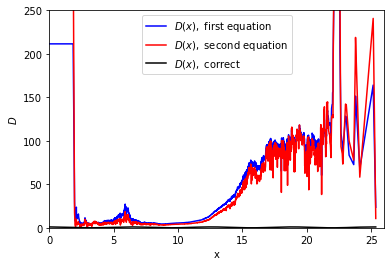

In [5]:
# compute Z_C,1, Z_C,-1 and Z_C
lx1,lzc1=comp_Zca(traj,a=1,dx=0.01)
lx2,lzcn1=comp_Zca(traj,a=-1,dx=0.01)
lx3,lzc=comp_Zca(traj,a=0,dx=0.01)

# compute diffusion coefficient using 1 and 2 equations
ld1=[zc1/zcn1/2/dt for zc1,zcn1 in zip(lzc1,lzcn1)]
ld2=[(zc/zcn1/2)**2/dt*math.pi for zc,zcn1 in zip(lzc,lzcn1)]

# make plot
plt.xlabel('x')
plt.ylabel('$D$')
plt.plot(lx1,ld1,'b',label='$D(x),$ first equation')
plt.plot(lx1,ld2,'r',label='$D(x),$ second equation')
plt.plot(lx1,[D(x) for x in lx1],'k',label='$D(x),$ correct')
plt.legend()
plt.xlim(0,26)
_=plt.ylim(0,250)

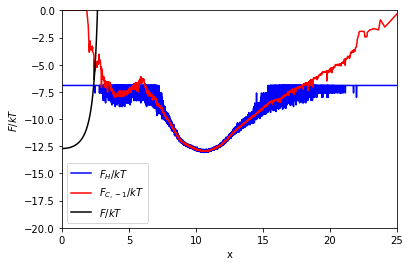

In [6]:
dx=0.001
# compute and plot F from Z_H
lx4,ly4=comp_Zh(traj,dx=dx)
lf4=[-math.log(y) for y in ly4]
plt.plot(lx4,lf4,'b-',label='$F_H/kT$')

# compute and plot F from Z_C,-1
lx5,ly5=comp_Zca(traj,a=-1,dx=dx)
lf5=[-math.log(2*y) for y in ly5]
plt.plot(lx5,lf5,'r-',label='$F_{C,-1}/kT$')


# compute and plot analytical free energy profile
lx=[i*0.01 for i in range(-300,301)]
lD=[D(x) for x in lx]
lfD=[-f(x)/D(x) for x in lx]
    
from scipy.integrate import cumtrapz
lI=cumtrapz(lfD,lx,initial=0)
lF=[I+math.log(D) for I,D in zip(lI,lD)]

# shift F, so that plots conside
du=lF[300]-lf5[int(len(lf5)/2)]
lF=[u-du for u in lF]

plt.plot(lx, lF,'k-',label='$F/kT$')

plt.legend()
plt.xlabel('x')
plt.ylim((-20,0))
plt.xlim((0,25))
_=plt.ylabel('$F/kT$')